# Семинар 2

# Обзор решений реранкинга для Retrieval-систем

Современные Retrieval-based диалоговые или поисковые системы работают примерно по одному сценарию. Упрощенно их можно представить следующим образом: 

![](./data/images/InformationRetrieval.png) 

На схеме указаны Bi-Encoder и Cross-Encoder, но на их месте могут быть другие произвольные компоненты, главное за что отвечают эти компоненты:
- фильтрация примеров на релевантность
- переранжирование выдачи для выдачи наиболее релевантных результатов

Классный обзор современных подходов можно посмотреть в [докладе](https://youtu.be/eoo5Kom7FXE?si=RwtU893y0X20pNxN) Саши Абрамова

Пример Bi-encoder системы может выглядеть следующим образом, конечно можно использовать предобученные системы, но дообучение дает дополнительный прирост качества.  
В качестве метрик качества тут может подойти как любая подходящая Metric learning метрик, но и обычная кросс-энтропия

![](./data/images/InformationRetrieval_2.png) 

Архитектура Cross-encoder`а может выглядеть примерно так:

![](./data/images/cross_encoder.png) 

Обучим простой Bi-encoder

In [1]:
import random
from typing import Callable, Iterable

import datasets
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModel
from transformers.optimization import get_linear_schedule_with_warmup
from scipy import stats
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

Сделаем наши тренировку более детерминированной, для воспроизводимости реультатов

In [3]:
seed = 10

random.seed(seed)
np.random.seed(seed)

torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Для работы возьмем корпус SNLI, который представляет собой коллекцию из 570 тыс. пар английских предложений, написанных и размеченных людьми метками "следствие", "противоречие" и "нейтральный". Решается задача логического следствия между двумя фразами - предпосылкой и гипотезой.

In [4]:
dataset = datasets.load_dataset("snli", split="train")

# there are some pairs of "premise" and "hypothesis" which haven't been
# labeled in this dataset, we will filter those out first
dataset = dataset.filter(lambda x: x["label"] != -1)

len(dataset), dataset[0]

(549367,
 {'premise': 'A person on a horse jumps over a broken down airplane.',
  'hypothesis': 'A person is training his horse for a competition.',
  'label': 1})

In [5]:
filtered_data = []
for data in tqdm(dataset):
    if random.random() < 0.8:
        filtered_data.append(data)
len(filtered_data)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 549367/549367 [00:11<00:00, 46487.90it/s]


439717

In [6]:
%%time

MAX_LENGTH = 128

tokenized_premises = tokenizer([data["premise"] for data in filtered_data],
                               max_length=MAX_LENGTH, padding="max_length",
                               truncation=True, verbose=True)

tokenized_hypothesis = tokenizer([data["hypothesis"] for data in filtered_data],
                                 max_length=MAX_LENGTH, padding="max_length",
                                 truncation=True, verbose=True)

CPU times: user 35.2 s, sys: 42.5 s, total: 1min 17s
Wall time: 11.6 s


### Задание 1

Напишите метод _init_data для инициализации данных. Вам необходимо проинициализировать атрибут data у Data-класса, записывая в него словари с ключами:
- premise_input_ids
- premise_attention_mask
- hypothesis_input_ids
- hypothesis_attention_mask
- label

В качестве значений в словаре следует хранить torch.Tensor`ы 

In [7]:
class SnliDataset(Dataset):
    def __init__(self, premise_tokens: dict, hypothesis_tokens: dict, labels: Iterable[str]):
        self.premise_tokens = premise_tokens
        self.hypothesis_tokens = hypothesis_tokens
        self.labels = labels
        self._init_data()

    def _init_data(self) -> None:
        self.data = []
        # YOUR_CODE_HERE

    def __getitem__(self, ix: int) -> dict[str, torch.tensor]:
        return self.data[ix]

    def __len__(self) -> int:
        return len(self.data)

In [8]:
# solved

class SnliDataset(Dataset):
    def __init__(self, premise_tokens: dict, hypothesis_tokens: dict, labels: Iterable[str]):
        self.premise_tokens = premise_tokens
        self.hypothesis_tokens = hypothesis_tokens
        self.labels = labels
        self._init_data()

    def _init_data(self) -> None:
        self.data = []
        for pt_ids, pt_am, ht_ids, ht_am, label in zip(
            self.premise_tokens["input_ids"], self.premise_tokens["attention_mask"],
            self.hypothesis_tokens["input_ids"], self.hypothesis_tokens["attention_mask"],
            self.labels
        ):
            data = {}
            data["premise_input_ids"] = torch.tensor(pt_ids, dtype=torch.long)
            data["premise_attention_mask"] = torch.tensor(pt_am, dtype=torch.long)
            data["hypothesis_input_ids"] = torch.tensor(ht_ids, dtype=torch.long)
            data["hypothesis_attention_mask"] = torch.tensor(ht_am, dtype=torch.long)
            data["label"] = torch.tensor(label, dtype=torch.long)
            self.data.append(data)

    def __getitem__(self, ix: int) -> dict[str, torch.tensor]:
        return self.data[ix]

    def __len__(self) -> int:
        return len(self.data)

In [9]:
def check_init_data(self):
    assert len(self.premise_tokens["input_ids"]) == len(self.premise_tokens["attention_mask"]) == \
           len(self.hypothesis_tokens["input_ids"]) == len(self.hypothesis_tokens["attention_mask"]), "Inconsistent lengths of input data."

    for item in self.data:
        assert isinstance(item, dict), "Each item in self.data should be a dictionary."
        assert all(key in item for key in ["premise_input_ids", "premise_attention_mask",
                                           "hypothesis_input_ids", "hypothesis_attention_mask", "label"]), \
               "Missing keys in data dictionary."
        assert all(isinstance(item[key], torch.Tensor) for key in item), \
               "All values in data dictionary should be torch.Tensor."
        assert all(item[key].dtype == torch.long for key in item), \
               "All tensors should have dtype torch.long."

        assert item["premise_input_ids"].shape[0] == len(self.premise_tokens["input_ids"][0]), \
               "Incorrect shape for premise_input_ids."

    print("All checks passed!")

SnliDataset.check_init_data = check_init_data

In [10]:
snli_dataset = SnliDataset(tokenized_premises, tokenized_hypothesis, (data["label"] for data in filtered_data))

In [11]:
snli_dataset.check_init_data()

All checks passed!


In [12]:
train_ratio = 0.8
n_total = len(snli_dataset)
n_train = int(n_total * train_ratio)
n_val = n_total - n_train

train_dataset, val_dataset = random_split(snli_dataset, [n_train, n_val])

batch_size = 16  # mentioned in the paper
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

Метод mean_pool() реализует стратегию mean_pooling, как в исходной [статье](https://arxiv.org/abs/1908.10084). Реализация была взята из библиотеки sentence_transformers.

In [14]:
def mean_pool(token_embeds: torch.tensor, attention_mask: torch.tensor) -> torch.tensor:
    in_mask = attention_mask.unsqueeze(-1).expand(token_embeds.size()).float()
    pool = torch.sum(token_embeds * in_mask, 1) / torch.clamp(in_mask.sum(1), min=1e-9)
    return pool


def encode(input_texts: list[str], tokenizer: AutoTokenizer, model: AutoModel, device: str = "cpu"
) -> torch.tensor:

    model.eval()
    tokenized_texts = tokenizer(input_texts, max_length=128,
                                padding='max_length', truncation=True, return_tensors="pt")
    token_embeds = model(tokenized_texts["input_ids"].to(device),
                         tokenized_texts["attention_mask"].to(device)).last_hidden_state
    pooled_embeds = mean_pool(token_embeds, tokenized_texts["attention_mask"].to(device))
    return pooled_embeds

In [15]:
class Sbert(torch.nn.Module):
    def __init__(self, max_length: int = 128):
        super().__init__()
        self.max_length = max_length
        self.bert_model = AutoModel.from_pretrained('distilbert-base-uncased')
        self.bert_tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
        self.linear = torch.nn.Linear(self.bert_model.config.hidden_size * 3, 3)

    def forward(self, data: datasets.arrow_dataset.Dataset) -> torch.tensor:
        premise_input_ids = data["premise_input_ids"].to(device)
        premise_attention_mask = data["premise_attention_mask"].to(device)
        hypothesis_input_ids = data["hypothesis_input_ids"].to(device)
        hypothesis_attention_mask = data["hypothesis_attention_mask"].to(device)

        out_premise = self.bert_model(premise_input_ids, premise_attention_mask)
        out_hypothesis = self.bert_model(hypothesis_input_ids, hypothesis_attention_mask)
        premise_embeds = out_premise.last_hidden_state
        hypothesis_embeds = out_hypothesis.last_hidden_state

        pooled_premise_embeds = mean_pool(premise_embeds, premise_attention_mask)
        pooled_hypotheses_embeds = mean_pool(hypothesis_embeds, hypothesis_attention_mask)

        embeds =  torch.cat([pooled_premise_embeds, pooled_hypotheses_embeds,
                             torch.abs(pooled_premise_embeds - pooled_hypotheses_embeds)],
                            dim=-1)
        return self.linear(embeds)

In [16]:
model = Sbert().to(device)

In [17]:
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-6)
total_steps = len(train_dataset) // batch_size
warmup_steps = int(0.1 * total_steps)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps,
                                            num_training_steps=total_steps - warmup_steps)

loss_fn = torch.nn.CrossEntropyLoss()

In [18]:
def get_train_step_fn(
    model: torch.nn.Module, optimizer: torch.optim.Optimizer,
    scheduler: torch.optim.lr_scheduler.LambdaLR, loss_fn: torch.nn.CrossEntropyLoss
) -> Callable[[torch.tensor, torch.tensor], float]:

    def train_step_fn(x: torch.tensor, y: torch.tensor) -> float:
        model.train()
        yhat = model(x)
        loss = loss_fn(yhat, y)
        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        return loss.item()

    return train_step_fn


def get_val_step_fn(
    model: torch.nn.Module, loss_fn: torch.nn.CrossEntropyLoss
) -> Callable[[torch.tensor, torch.tensor], float]:

    def val_step_fn(x: torch.tensor, y: torch.tensor) -> float:
        model.eval()
        yhat = model(x)
        loss = loss_fn(yhat, y)
        return loss.item()

    return val_step_fn


def mini_batch(
    dataloader: DataLoader,
    step_fn: Callable[[torch.tensor, torch.tensor], float],
    is_training: bool = True
) -> tuple[np.array, list[float]]:

    mini_batch_losses = []

    if is_training:
        print("\nTraining ...")
    else:
        print("\nValidating ...")
    n_steps = len(dataloader)
    for i, data in enumerate(dataloader):
        loss = step_fn(data, data["label"].to(device))
        mini_batch_losses.append(loss)
        if i % (batch_size * 100) == 0:
            print(f"step {i:>5}/{n_steps}, loss = {loss: .3f}")

    return np.mean(mini_batch_losses), mini_batch_losses

Можем запустить обучение нашей модели, одна эпоха учиться примерно 30 минут

In [19]:
%%time

n_epochs = 1  # mentioned in the paper

train_step_fn = get_train_step_fn(model, optimizer, scheduler, loss_fn)
val_step_fn = get_val_step_fn(model, loss_fn)

train_losses, train_mini_batch_losses = [], []
val_losses, val_mini_batch_losses = [], []

for epoch in range(1, n_epochs + 1):
    train_loss, _train_mini_batch_losses = mini_batch(train_dataloader, train_step_fn)
    train_mini_batch_losses += _train_mini_batch_losses
    train_losses.append(train_loss)

    with torch.no_grad():
        val_loss, _val_mini_batch_losses = mini_batch(val_dataloader, val_step_fn, is_training=False)
        val_mini_batch_losses += _val_mini_batch_losses
        val_losses.append(val_loss)


Training ...
step     0/21986, loss =  1.111
step  1600/21986, loss =  0.960
step  3200/21986, loss =  0.708
step  4800/21986, loss =  0.756
step  6400/21986, loss =  0.533
step  8000/21986, loss =  1.042
step  9600/21986, loss =  0.917
step 11200/21986, loss =  0.565
step 12800/21986, loss =  0.880
step 14400/21986, loss =  1.046
step 16000/21986, loss =  0.429
step 17600/21986, loss =  0.889
step 19200/21986, loss =  0.903
step 20800/21986, loss =  0.666

Validating ...
step     0/5497, loss =  0.508
step  1600/5497, loss =  0.711
step  3200/5497, loss =  0.831
step  4800/5497, loss =  0.820
CPU times: user 23min 15s, sys: 28.1 s, total: 23min 43s
Wall time: 23min 44s


In [20]:
model.bert_model.save_pretrained("models/sbert_softmax_lr_2e-6")

In [21]:
window_size = 32

train_mb_running_loss = []
for i in range(len(train_mini_batch_losses)-window_size):
    train_mb_running_loss.append(np.mean(train_mini_batch_losses[i:i+window_size]))

val_mb_running_loss = []
for i in range(len(val_mini_batch_losses)-window_size):
    val_mb_running_loss.append(np.mean(val_mini_batch_losses[i:i+window_size]))

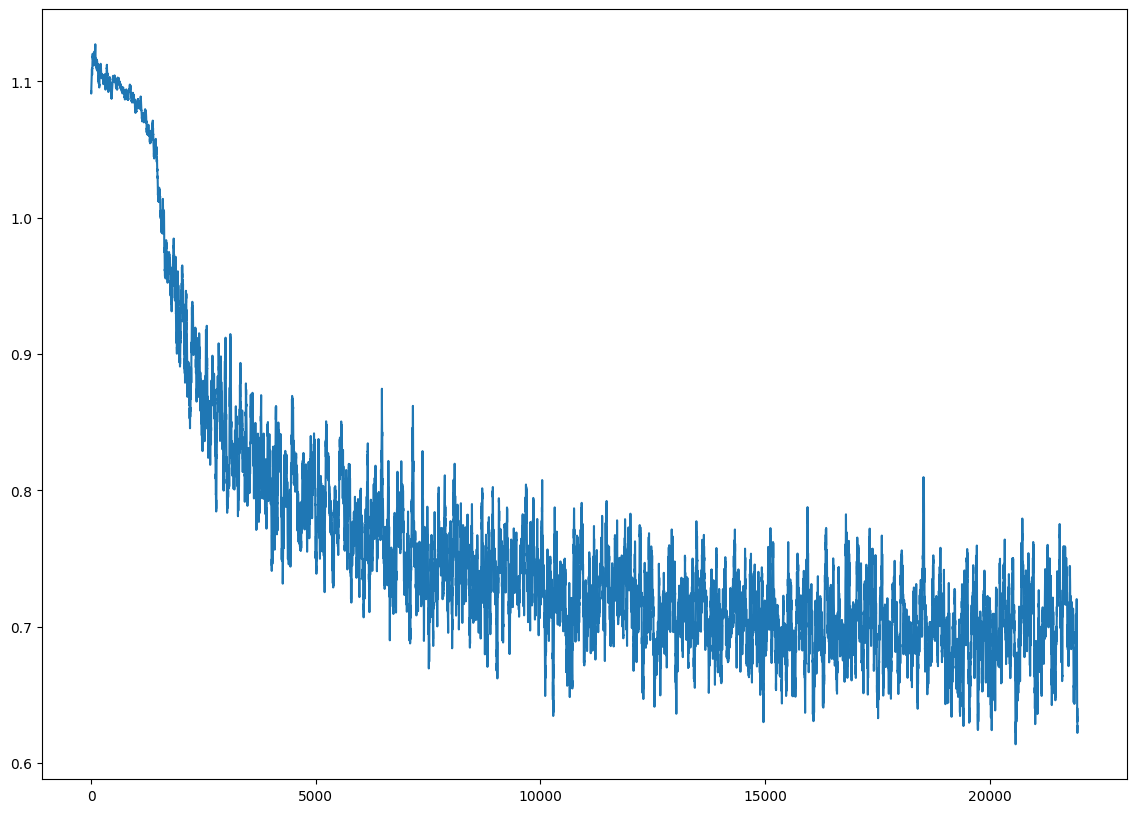

In [22]:
fix, ax = plt.subplots(figsize=(14, 10))
ax.plot(range(len(train_mb_running_loss)), train_mb_running_loss);

Давайте отрисуем матрицу похожести для произвольных предложений 

In [23]:
def plot_heatmap(similarity_matrix: np.array, sentences: list[str]) -> None:
    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(similarity_matrix, cmap='YlGn', interpolation='nearest')

    ax.set_yticks(np.arange(len(sentences)), labels=[txt[:50] + "..." for txt in sentences])
    ax.set_xticks(np.arange(len(sentences)), labels=[txt[:50] + "..." for txt in sentences])

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    for i in range(len(sentences)):
        for j in range(len(sentences)):
            text = ax.text(j, i, round(similarity_matrix[i, j], 2),
                           ha="center", va="center", color="w")

    fig.tight_layout()
    plt.show()

Для простоты давайте попробуем взять несколько предложений, которые соответствуют трем тематическим кластерам

In [24]:
sentences = [
    "What should I do to improve my English ?",
    "What should I do to improve my spoken English?",
    "Can I improve my English?",
    "How can I earn money online?",
    "How do I earn money online?",
    "Can I earn money online?",
    "What are some mind-blowing Mobile gadgets that exist that most people don't know about?",
    "What are some mind-blowing gadgets and technologies that exist that most people don't know about?",
    "What are some mind-blowing mobile technology tools that exist that most people don't know about?"
]

In [25]:
pooled_embeds = encode(sentences, model.bert_tokenizer, model.bert_model, device)
pooled_embeds = pooled_embeds.cpu().detach().numpy()

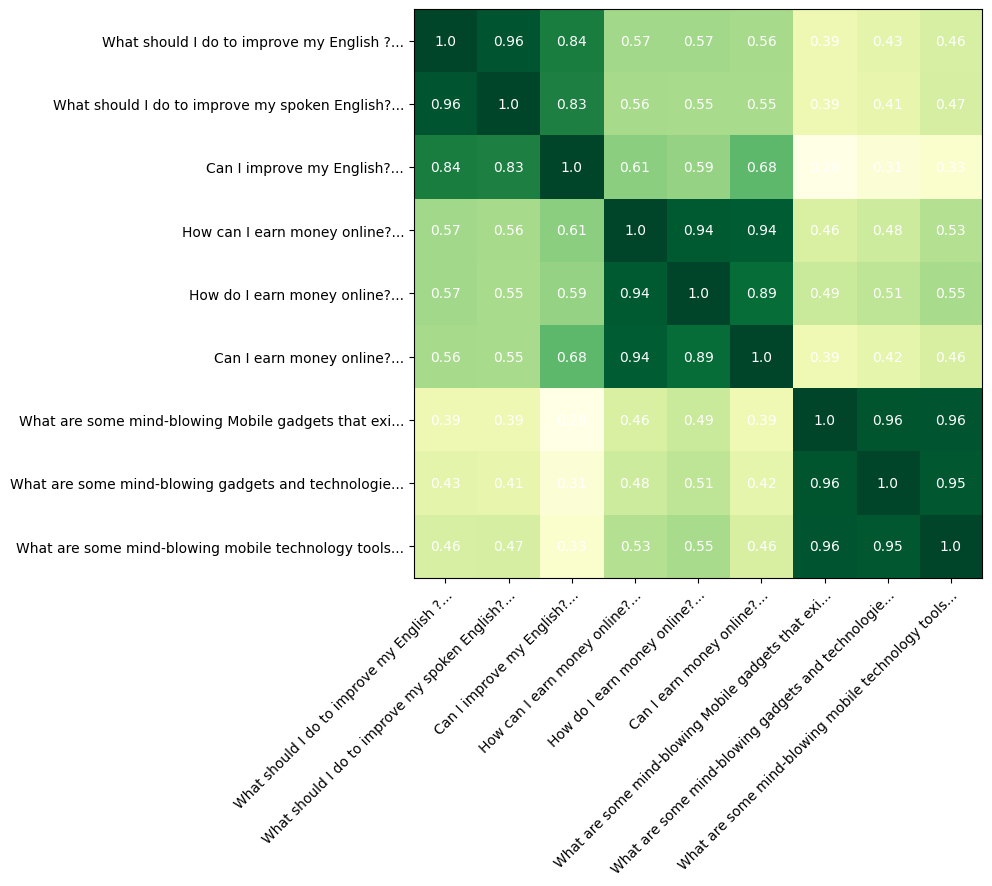

In [26]:
similarity_matrix = cosine_similarity(pooled_embeds)
plot_heatmap(similarity_matrix, sentences)

Теперь давайте сделаем тоже самое для обычной предобученной модели

In [27]:
bert_model = AutoModel.from_pretrained("distilbert-base-uncased")

In [28]:
pooled_embeds = encode(sentences, tokenizer, bert_model, "cpu")
pooled_embeds = pooled_embeds.detach().numpy()

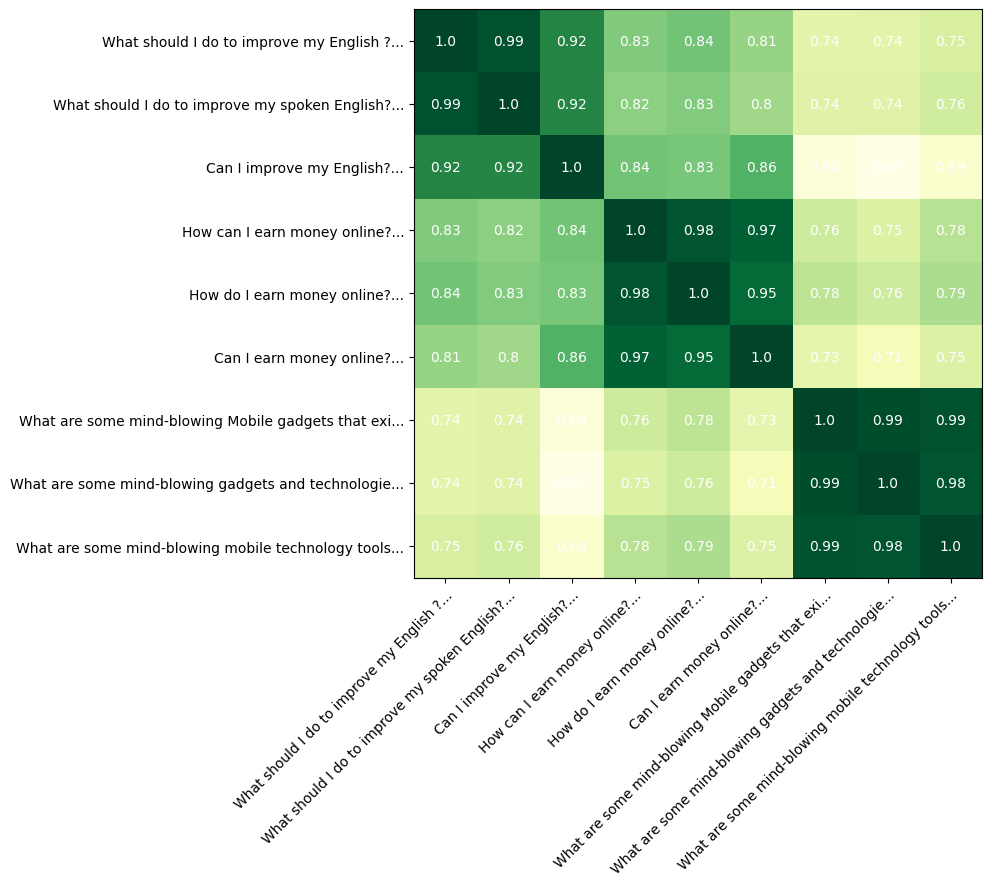

In [29]:
similarity_matrix = cosine_similarity(pooled_embeds)
plot_heatmap(similarity_matrix, sentences)

Как видите модель после тренировки стала куда увереннее в своих предсказаниях и лучше разделять похожие кластера

## Training Cross-Encoder

Давайте попробуем теперь слудующий подход, который вам может пригодится при решении домашнего задания, который ранжирует финальную выдачу из k-кандидатов 

Cross-Encoder работают лучше, чем Bi-Encoder, согласно оригинальной статье Sentence-BERT. Однако они невсегда практичны для ряда приложений, поскольку мы не можем использовать их для предварительного вычисления и индексации наших вложений в контекст/документ. Однако в задачах где требуется более точное ранжирование зачастую используют тяжелые и более надежные модели, которые выбивают максимально возможный скор. Вопрос ускорения работы модели сейчас уже не является таким нерешаемым или сложно выполнимым.

Cross-Encoders обычно используются как Re-Ranker.

Это наиболее распространенная схема для семантического поиска. Мы передаем нашу коллекцию документов через Bi-Encoder, настроенный для задач STS (семантическое текстовое сопоставление), и индексируем вложения в векторной базе данных.

Во время запроса мы встраиваем запрос с использованием того же Bi-Encoder и извлекаем топ-k кандидатов из нашей базы данных. Это и есть часть извлечения информации.

Далее, мы можем дополнительно уточнить результаты, передавая top-k пар (запрос, извлеченный документ) через Cross-Encoder, настроенный для задач STS. Cross-Encoder по сути пересортирует извлеченные кандидатные документы таким образом, чтобы самый релевантный документ оказался на вершине со своим наивысшим баллом.

In [30]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
bert_model = AutoModel.from_pretrained("distilbert-base-uncased")

In [31]:
# example of next sentence prediction objective used for a cross encoder
tokenized_texts = tokenizer(["I am hungry."], ["Order some food for me"], padding=True, truncation=True)
tokenizer.decode(tokenized_texts["input_ids"][0])

'[CLS] i am hungry. [SEP] order some food for me [SEP]'

Для нашей задачи возьмем датасет с парами предложений, которые размечены на задачу Semantic Textual Similarity - то есть решается задача, насколько они похожи в семантическом смысле

In [32]:
dataset = datasets.load_dataset("glue", "stsb", split="train")
len(dataset), dataset[0]

(5749,
 {'sentence1': 'A plane is taking off.',
  'sentence2': 'An air plane is taking off.',
  'label': 5.0,
  'idx': 0})

In [33]:
text_lengths1, text_lengths2 = [], []
for data in tqdm(dataset):
    if random.random() > 0.5:
        text_lengths1.append(len(data["sentence1"]))
        text_lengths2.append(len(data["sentence2"]))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5749/5749 [00:00<00:00, 73601.35it/s]


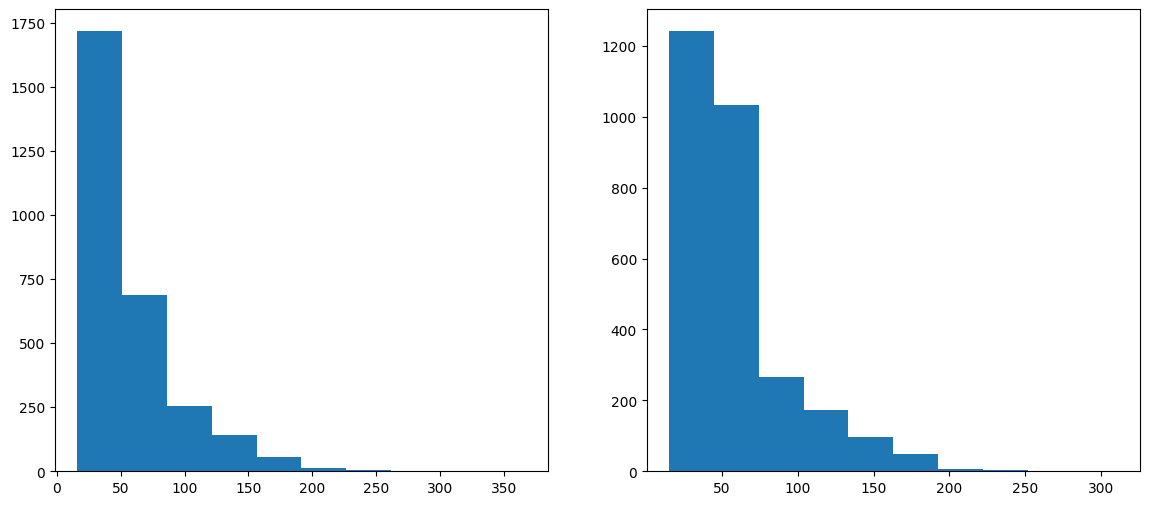

In [34]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
ax[0].hist(text_lengths1)
ax[1].hist(text_lengths2);

In [35]:
%%time

MAX_LENGTH = 128

tokenized_texts = tokenizer([data["sentence1"] for data in dataset],
                            [data["sentence2"] for data in dataset],
                            max_length=MAX_LENGTH, padding="max_length",
                            truncation=True, verbose=True)

CPU times: user 612 ms, sys: 0 ns, total: 612 ms
Wall time: 184 ms


Создадим самый простой датасет для данной задачи

In [36]:
class StsDataset(Dataset):
    def __init__(self, tokens: dict, labels: list[float]):
        self.tokens = tokens
        self.labels = labels

    def __getitem__(self, ix: int) -> dict[str, torch.tensor]:
        return {
            "input_ids": torch.tensor(self.tokens["input_ids"][ix], dtype=torch.long),
            "attention_mask": torch.tensor(self.tokens["attention_mask"][ix], dtype=torch.long),
            "labels": torch.tensor(self.labels[ix], dtype=torch.float)  # Use float for regression
        }

    def __len__(self) -> int:
        return len(self.tokens["input_ids"])


In [37]:
%%time

sts_dataset = StsDataset(tokenized_texts, [data["label"] for data in dataset])

CPU times: user 83.2 ms, sys: 0 ns, total: 83.2 ms
Wall time: 82.8 ms


In [38]:
train_ratio = 0.8
n_total = len(sts_dataset)
n_train = int(n_total * train_ratio)
n_val = n_total - n_train

train_dataset, val_dataset = random_split(sts_dataset, [n_train, n_val])

batch_size = 16  # mentioned in the paper
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [39]:
len(train_dataloader), len(val_dataloader)

(288, 72)

### Задание 2

Напишите метод `__init__` и метод forward для класса CrossEncoderBert.  
модель должна включать в себя BERT-like модель и поверх нее должен стоять линейный слой.
Метод forward должен включать в себя получение CLS-эмбединга от BERT-like модели и передачаа его на линейный слой

In [40]:
class CrossEncoderBert(torch.nn.Module):
    def __init__(self, max_length: int = MAX_LENGTH):
        super().__init__()
        self.max_length = max_length
        self.bert_model = AutoModel.from_pretrained('distilbert-base-uncased')
        self.bert_tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
        self.linear = torch.nn.Linear(self.bert_model.config.hidden_size, 1)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert_model(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0]  # Use the CLS token's output
        return self.linear(pooled_output)

In [41]:
# solved

class CrossEncoderBert(torch.nn.Module):
    def __init__(self, max_length: int = MAX_LENGTH):
        super().__init__()
        self.max_length = max_length
        self.bert_model = AutoModel.from_pretrained('distilbert-base-uncased')
        self.bert_tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
        self.linear = torch.nn.Linear(self.bert_model.config.hidden_size, 1)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert_model(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0]  # Use the CLS token's output
        return self.linear(pooled_output)

In [42]:
def test_cross_encoder_bert():
    max_length = 128
    model = CrossEncoderBert(max_length=max_length)

    # Check __init__ method
    assert model.max_length == max_length, "Incorrect max_length initialization"
    assert isinstance(model.linear, torch.nn.Linear), "linear is not an instance of torch.nn.Linear"
    assert model.linear.in_features == model.bert_model.config.hidden_size, "Incorrect input size for linear layer"

    # Prepare dummy data for forward method check
    input_text = ["Hello, world!"]
    inputs = model.bert_tokenizer(input_text, return_tensors="pt", max_length=max_length, truncation=True, padding=True)
    input_ids = inputs["input_ids"]
    attention_mask = inputs["attention_mask"]

    # Check forward method
    output = model(input_ids, attention_mask)
    assert output.shape == (1, 1), "Output shape is incorrect"

    print("All checks passed!")

test_cross_encoder_bert()

All checks passed!


In [43]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = CrossEncoderBert().to(device)

Используем MSE loss потому что по сути решаем задачу регрессии, но вы можете придумать что-то более сложное

In [44]:
#  optimizer, lr, num_warmup steps have been picked from the paper
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-5)
total_steps = len(train_dataset) // batch_size
warmup_steps = int(0.1 * total_steps)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps,
                                            num_training_steps=total_steps - warmup_steps)

loss_fn = torch.nn.MSELoss()

In [45]:
def train_step_fn(model, optimizer, scheduler, loss_fn, batch):
    model.train()
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['labels'].to(device)
    optimizer.zero_grad()
    logits = model(input_ids, attention_mask)
    loss = loss_fn(logits.squeeze(-1), labels)
    loss.backward()
    optimizer.step()
    scheduler.step()
    return loss.item()

def val_step_fn(model, loss_fn, batch):
    model.eval()
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['labels'].to(device)
    with torch.no_grad():
        logits = model(input_ids, attention_mask)
    loss = loss_fn(logits.squeeze(-1), labels)
    return loss.item()
    
def mini_batch(dataloader, step_fn, is_training=True):
    mini_batch_losses = []
    for i, batch in enumerate(dataloader):
        if is_training:
            loss = step_fn(model, optimizer, scheduler, loss_fn, batch)
        else:
            loss = step_fn(model, loss_fn, batch)
        mini_batch_losses.append(loss)
        if i % (batch_size * 4) == 0:
            print(f"Step {i:>5}/{len(dataloader)}, Loss = {loss:.3f}")
    return np.mean(mini_batch_losses), mini_batch_losses

Запустим обучение нашей модели

In [46]:
%%time

n_epochs = 2

train_losses, train_mini_batch_losses = [], []
val_losses, val_mini_batch_losses = [], []

for epoch in range(1, n_epochs + 1):
    print(f"\nEpoch {epoch}")
    train_loss, _train_mini_batch_losses = mini_batch(train_dataloader, train_step_fn, is_training=True)
    train_mini_batch_losses.extend(_train_mini_batch_losses)
    train_losses.append(train_loss)

    with torch.no_grad():
        val_loss, _val_mini_batch_losses = mini_batch(val_dataloader, val_step_fn, is_training=False)
        val_mini_batch_losses.extend(_val_mini_batch_losses)
        val_losses.append(val_loss)


Epoch 1
Step     0/288, Loss = 7.397
Step    64/288, Loss = 1.390
Step   128/288, Loss = 0.832
Step   192/288, Loss = 0.629
Step   256/288, Loss = 1.045
Step     0/72, Loss = 0.659
Step    64/72, Loss = 0.602

Epoch 2
Step     0/288, Loss = 0.610
Step    64/288, Loss = 0.571
Step   128/288, Loss = 0.680
Step   192/288, Loss = 0.519
Step   256/288, Loss = 1.164
Step     0/72, Loss = 0.659
Step    64/72, Loss = 0.602
CPU times: user 21 s, sys: 11.6 ms, total: 21 s
Wall time: 21 s


In [47]:
window_size = 32

train_mb_running_loss = []
for i in range(len(train_mini_batch_losses)-window_size):
    train_mb_running_loss.append(np.mean(train_mini_batch_losses[i:i+window_size]))

val_mb_running_loss = []
for i in range(len(val_mini_batch_losses)-window_size):
    val_mb_running_loss.append(np.mean(val_mini_batch_losses[i:i+window_size]))

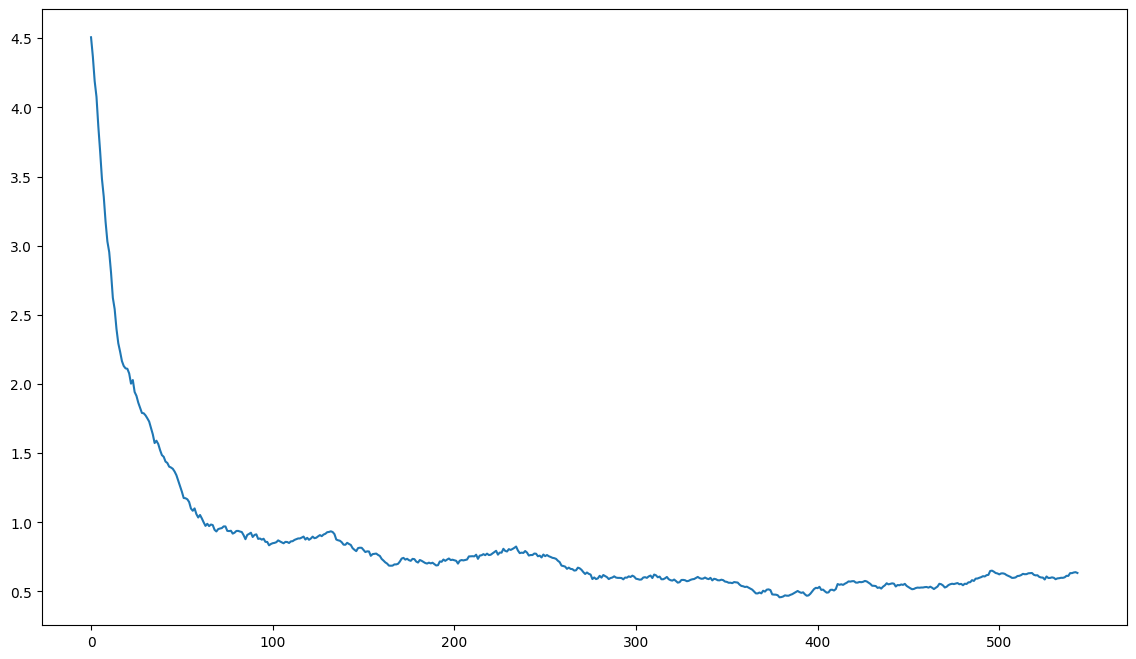

In [48]:
fix, ax = plt.subplots(figsize=(14, 8))
ax.plot(range(len(train_mb_running_loss)), train_mb_running_loss);

Напишем функцию ранжирующую условную текстовую выдачу

In [49]:
def get_ranked_docs(
    tokenizer: AutoTokenizer, finetuned_ce: CrossEncoderBert,
    base_bert: AutoModel, query: str, corpus: list[str]
) -> None:

    queries = [query] * len(corpus)
    tokenized_texts = tokenizer(
        queries, corpus, max_length=MAX_LENGTH, padding=True, truncation=True, return_tensors="pt"
    ).to(device)

    # Finetuned CrossEncoder model scoring
    with torch.no_grad():
        ce_scores = finetuned_ce(tokenized_texts['input_ids'], tokenized_texts['attention_mask']).squeeze(-1)
        ce_scores = torch.sigmoid(ce_scores)  # Apply sigmoid if needed

    # Base Bert model scoring
    with torch.no_grad():
        base_bert_outputs = base_bert(**tokenized_texts)
        bert_scores = torch.sigmoid(finetuned_ce.linear(base_bert_outputs.last_hidden_state[:, 0, :]))  # Use CLS token output

    # Process scores for finetuned model
    print(f"Query - {query} [Finetuned Cross-Encoder]\n---")
    scores = ce_scores.cpu().numpy()
    scores_ix = np.argsort(scores)[::-1]
    for ix in scores_ix:  # Limit to corpus size
        print(f"{scores[ix]: >.2f}\t{corpus[ix]}")

    # Process scores for base Bert model
    print(f"\nQuery - {query} [Bert Base]\n---")
    scores = bert_scores.cpu().numpy().squeeze(-1)
    scores_ix = np.argsort(scores)[::-1]
    for ix in scores_ix:  # Limit to corpus size
        print(f"{scores[ix]: >.2f}\t{corpus[ix]}")

In [50]:
corpus = [
    "A man is eating food.",
    "A man is eating a piece of bread.",
    "The girl is carrying a baby.",
    "A man is riding a horse.",
    "A woman is playing violin.",
    "Two men pushed carts through the woods.",
    "A man is riding a white horse on an enclosed ground.",
    "A monkey is playing drums.",
    "A cheetah is running behind its prey."
]

query = "A man is eating pasta."

In [51]:
get_ranked_docs(tokenizer, model, bert_model.to(device), query, corpus)

Query - A man is eating pasta. [Finetuned Cross-Encoder]
---
0.93	A man is eating food.
0.88	A man is eating a piece of bread.
0.52	A man is riding a horse.
0.50	A man is riding a white horse on an enclosed ground.
0.48	Two men pushed carts through the woods.
0.45	A cheetah is running behind its prey.
0.44	The girl is carrying a baby.
0.40	A monkey is playing drums.
0.39	A woman is playing violin.

Query - A man is eating pasta. [Bert Base]
---
0.62	A man is eating food.
0.61	A man is eating a piece of bread.
0.60	A man is riding a white horse on an enclosed ground.
0.60	A man is riding a horse.
0.60	A cheetah is running behind its prey.
0.60	The girl is carrying a baby.
0.59	A monkey is playing drums.
0.59	A woman is playing violin.
0.59	Two men pushed carts through the woods.


Как видим модель после обучения отлично научилась ранжировать поисковую выдачу для последующего использования

In [52]:
corpus = [
    "A man is eating food.",
    "A man is eating a piece of bread.",
    "A woman is playing violin.",
    "Two men pushed carts through the woods.",
    "A woman is practicing jumps with her horse.",
    "A horse is running around the track."
]

query = "Horse jumped over the obstacle."

In [53]:
get_ranked_docs(tokenizer, model, bert_model, query, corpus)

Query - Horse jumped over the obstacle. [Finetuned Cross-Encoder]
---
0.97	A woman is practicing jumps with her horse.
0.97	A horse is running around the track.
0.58	Two men pushed carts through the woods.
0.52	A man is eating a piece of bread.
0.51	A man is eating food.
0.42	A woman is playing violin.

Query - Horse jumped over the obstacle. [Bert Base]
---
0.60	A woman is practicing jumps with her horse.
0.60	A horse is running around the track.
0.59	A woman is playing violin.
0.59	A man is eating a piece of bread.
0.59	A man is eating food.
0.58	Two men pushed carts through the woods.
